# Intro

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
import json
from unidecode import unidecode
from nltk.tokenize import word_tokenize
import community 
import os
from collections import Counter
import re
from collections import defaultdict, Counter
from nltk.tokenize import word_tokenize
import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from afinn import Afinn

# 1 Import data 

In [2]:
def clean_name(name):
    name = name.replace('"', '')
    return unidecode(name)

In [3]:
# Read the data from the csv file
senate_df = pd.read_csv('usa_data/senators.csv')
house_df = pd.read_csv('usa_data/house.csv')

# clean all names
senate_df['Senator'] = senate_df['Senator'].apply(clean_name)
house_df['Member'] = house_df['Member'].apply(clean_name)

senators = senate_df['Senator'].tolist()
representatives = house_df['Member'].tolist()

senators_names = [clean_name(name) for name in senators]
representatives = [clean_name(name) for name in representatives]

# remove representatives that are vacant
representatives = [x for x in representatives if x != 'Vacant']

In [4]:
# load the JSON string back into a dictionary
with open('usa_data/house_links.json', 'r') as f:
    house_links = json.loads(f.read())

with open('usa_data/senate_links.json', 'r') as f:
    senate_links = json.loads(f.read())

## 1.1 Create graph 

In [5]:
# create a graph object
congress_dict = {**house_links, **senate_links}

congress_graph = nx.DiGraph(congress_dict)

party = senate_df['Party'].unique().tolist()

# add house, senate and state attributes to the nodes
for node in congress_graph.nodes():
    if node in senators:
        congress_graph.nodes[node]['chamber'] = 'Senate'
        congress_graph.nodes[node]['party'] = senate_df.loc[senate_df['Senator'] == node]['Party'].values[0]
        congress_graph.nodes[node]['state'] = senate_df.loc[senate_df['Senator'] == node]['State'].values[0]
        

    elif node in representatives:
        congress_graph.nodes[node]['chamber'] = 'House'
        congress_graph.nodes[node]['party'] = house_df.loc[house_df['Member'] == node]['Party'].values[0]
        congress_graph.nodes[node]['state'] = house_df.loc[house_df['Member'] == node]['District'].values[0]
        
        #print(house_df.loc[house_df['Member'] == node]['Party'].values)


print(congress_graph)

# to do, remove number on district

DiGraph with 534 nodes and 3007 edges


In [6]:
#print number of republican in house and senate"
print(len([node for node in congress_graph.nodes() if congress_graph.nodes[node]['party'] == 'Republican']))
print(len([node for node in congress_graph.nodes() if congress_graph.nodes[node]['party'] == 'Democratic']))
print([node for node in congress_graph.nodes() if congress_graph.nodes[node]['party'] != 'Republican' and congress_graph.nodes[node]['party'] != 'Democratic'])

270
259
['Kyrsten Sinema', 'Angus King', 'Amy Klobuchar', 'Tina Smith', 'Bernie Sanders']


In [7]:
# find most connected node based on House

# find most connected rappers from east and west coast
in_degrees = sorted(congress_graph.in_degree, key=lambda x: x[1], reverse=True)
out_degrees = sorted(congress_graph.out_degree, key=lambda x: x[1], reverse=True)

in_house = []
in_senate = []
out_house = []
out_senate = []

for node in in_degrees:
    if congress_graph.nodes[node[0]]['chamber'] == 'House':
        in_house.append(node)
    else:
        in_senate.append(node)

for node in out_degrees:
    if congress_graph.nodes[node[0]]['chamber'] == 'House':
        out_house.append(node)
    else:
        out_senate.append(node)


In [8]:
# Most connected east coast rappers
print("Top 5 highest out-degree members of house of representatives:")
for i in range(5):
    print(str(i+1)+ ")"+str(out_house[i])[1:-1])

print("\n")
print("Top 5 highest out-degree members of senate:")
for i in range(5):
    print(str(i+1)+ ")"+str(out_senate[i])[1:-1])

Top 5 highest out-degree members of house of representatives:
1)'Marjorie Taylor Greene', 34
2)'Chip Roy', 31
3)'Kevin McCarthy', 27
4)'Alexandria Ocasio-Cortez', 27
5)'Josh Gottheimer', 21


Top 5 highest out-degree members of senate:
1)'Joe Manchin', 31
2)'Chuck Schumer', 24
3)'Tom Cotton', 22
4)'Ron Wyden', 22
5)'Bernie Sanders', 22


In [9]:
# Most connected east coast rappers
print("Top 5 highest in-degree members of house of representatives:")
for i in range(5):
    print(str(i+1)+ ")"+str(in_house[i])[1:-1])

print("\n")
print("Top 5 highest in-degree members of senate:")
for i in range(5):
    print(str(i+1)+ ")"+str(in_senate[i])[1:-1])

Top 5 highest in-degree members of house of representatives:
1)'Nancy Pelosi', 100
2)'Kevin McCarthy', 69
3)'Marjorie Taylor Greene', 32
4)'Alexandria Ocasio-Cortez', 32
5)'Jim Jordan', 24


Top 5 highest in-degree members of senate:
1)'Bernie Sanders', 63
2)'Ted Cruz', 43
3)'Mitch McConnell', 40
4)'Chuck Schumer', 40
5)'Elizabeth Warren', 38


In [10]:
house_df.loc[house_df["Member"] == "Nancy Pelosi"]

District        Member       Party  \
31  California 11  Nancy Pelosi  Democratic   

                     Prior experience                           Education  \
31  California Democratic Party Chair  Trinity Washington University (BA)   

    Assumed office      Residence   Age  
31  1987 (special)  San Francisco  83.0

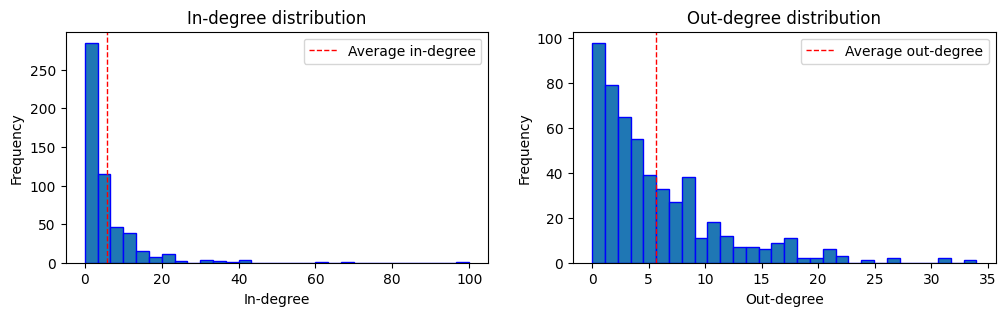

In [11]:
# Make histogram of in and out degree graph
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
plt.hist([x[1] for x in in_degrees], bins=30, edgecolor='blue')
# make line with average
plt.axvline(np.mean([x[1] for x in in_degrees]), color='red', linestyle='dashed', linewidth=1, label = 'Average in-degree')
plt.title('In-degree distribution')
plt.xlabel('In-degree')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1,2,2)
plt.hist([x[1] for x in out_degrees], bins=30, edgecolor='blue')
# make line with average
plt.axvline(np.mean([x[1] for x in out_degrees]), color='red', linestyle='dashed', linewidth=1 , label = 'Average out-degree')
plt.title('Out-degree distribution')
plt.xlabel('Out-degree')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('usa_data/degree_distribution.pdf', bbox_inches='tight')
plt.show()

In [12]:
# draw the graph

color = []

top_15_degree = sorted(congress_graph.degree, key=lambda x: x[1], reverse=True)[:15]
top_15_degree_dict = [x[0] for x in top_15_degree]
label_vec = {}

for node in congress_graph.nodes():
    if node in top_15_degree_dict:
        label_vec[node] = node
    if congress_graph.nodes[node]['party'] == 'Republican':
        color.append('red')
    elif congress_graph.nodes[node]['party'] == 'Democratic':
        color.append('blue')
    else:
        color.append('green')

color2 = []
for node in congress_graph.nodes():
    if congress_graph.nodes[node]['chamber'] == 'House':
        color2.append('purple')
    else:
        color2.append('green')

size = [degree*5 for node, degree in congress_graph.degree()]


In [13]:
pos = nx.kamada_kawai_layout(congress_graph)

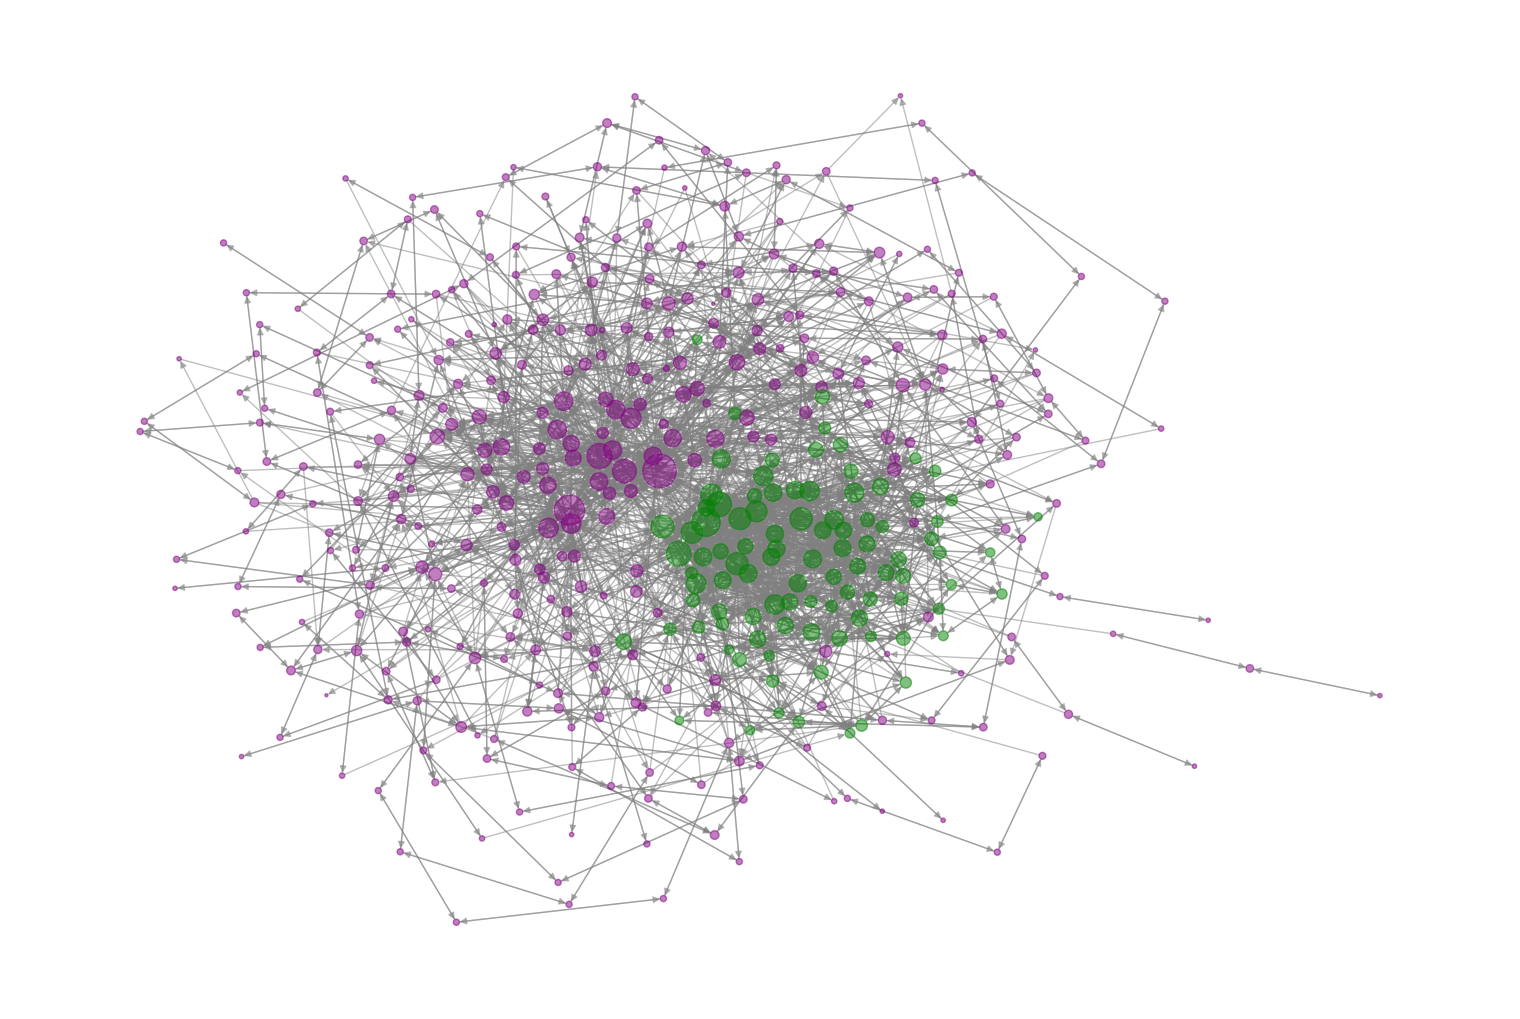

In [14]:
plt.figure(figsize=(15,10))
# remove self loops
congress_graph.remove_edges_from(nx.selfloop_edges(congress_graph))
nx.draw(congress_graph, pos, font_size=8, node_color=color2, node_size=size, edge_color= "gray",alpha=0.5)

# draw labels for top 15 degree centrality nodes
#nx.draw_networkx_labels(congress_graph,pos,labels=label_vec,font_size=10,font_color='black')
plt.savefig("usa_data/congress_graph.pdf")

In [15]:
# create table with all the nodes stats
stats_df = pd.DataFrame()

for node in congress_graph.nodes():
    new_row = pd.DataFrame([[node, 
                            congress_graph.in_degree(node),
                            congress_graph.out_degree(node), 
                            nx.degree_centrality(congress_graph)[node]
                            ]])
    stats_df = pd.concat([stats_df,new_row], axis = 0, ignore_index=True)


# set the column names
stats_df.columns = ['Name', 'In-degree', 'Out-degree', 'Degree centrality']
print(stats_df)

                     Name  In-degree  Out-degree  Degree centrality
0              Jerry Carl          3           2           0.009381
1             Barry Moore          0           0           0.000000
2             Mike Rogers          0           0           0.000000
3         Robert Aderholt          2           4           0.011257
4             Dale Strong          1           2           0.005629
..                    ...        ...         ...                ...
529  Shelley Moore Capito          9          18           0.050657
530           Ron Johnson         10           9           0.035647
531         Tammy Baldwin         14          17           0.058161
532         John Barrasso          9          11           0.037523
533        Cynthia Lummis          7          10           0.031895

[534 rows x 4 columns]


In [16]:
# print nodes with highest degree centrality
print("Top 5 highest degree centrality:")
print(stats_df.sort_values(by=['Degree centrality'], ascending=False).head(10))

Top 5 highest degree centrality:
                         Name  In-degree  Out-degree  Degree centrality
31               Nancy Pelosi        100          18           0.221388
40             Kevin McCarthy         69          27           0.180113
522            Bernie Sanders         63          22           0.159475
128    Marjorie Taylor Greene         32          34           0.123827
519                  Ted Cruz         43          21           0.120075
496             Chuck Schumer         40          24           0.120075
269  Alexandria Ocasio-Cortez         32          27           0.110694
474          Elizabeth Warren         38          17           0.103189
528               Joe Manchin         21          31           0.097561
512            Lindsey Graham         30          21           0.095685


# 2 Communities 

In [17]:
# Convert to undirected graph
congress_graph_undirected = congress_graph.to_undirected()

## 2.1 Extract degrees 

Calculate modularity bewteen republicans and democrats.

In [18]:
import re
def extract_degrees(data):
    degrees = re.findall(r'\(([^)]*)\)', data)
    # check if degrees are 
    if len(degrees) != 0:
        degrees = degrees[-1]
        degrees = degrees.split(',')[-1]
        # remove blank spaces
        degrees = degrees.strip()
    else:
        degrees = "None"
    return degrees

# extract name and education from dataframe
house_name_edu_df = house_df[['Member', 'Education']]
senate_name_edu_df = senate_df[['Senator', 'Education']]

# rename columns
house_name_edu_df.columns = ['Name', 'Education']
senate_name_edu_df.columns = ['Name', 'Education']

#concatenate the two dataframes
name_edu_df = pd.concat([house_name_edu_df, senate_name_edu_df], ignore_index=True)
# add copy of name column
name_edu_df['Degree'] = name_edu_df['Education']
name_edu_df['Degree'] = name_edu_df['Degree'].apply(extract_degrees)

In [19]:
def extract_institution(data):
    # Use re.sub to replace the specified pattern in the data
    data = re.sub(r'\(([^)]*)\)', ",", data)
    # Split degrees if multiple degrees
    # Uncomment the next line if you want to split degrees based on commas
    data = [d for d in data.split(',')]
    
    # remove leading and trailing whitespace
    data = [d.strip() for d in data]

    # remove empty strings
    data = [d for d in data if d != '']
    data = data[-1]
    return data

name_edu_df['Institution'] = name_edu_df['Education'].apply(extract_institution)

In [20]:
# obtain a list with all the institutions
all_universities = set(name_edu_df['Institution'].tolist())

print("Number of unique institutions")
print(len(all_universities))

# create a dictionary with the names of politicians who have a degree from each institution
institutions_dict = {}
for i in all_universities:
    institutions_dict[i] = []

for _,row in name_edu_df.iterrows():
        name = row['Name']
        institutions1 = row['Institution']
        institutions_dict[institutions1].append(name)

Number of unique institutions
318


In [21]:
# obtain a list with all the institutions
all_degrees = set(name_edu_df['Degree'].tolist())

print("Number of unique degrees")
print(len(all_degrees))

# create a dictionary with the names of politicians who have a degree from each institution
degrees_dict = {}
for i in all_degrees:
    degrees_dict[i] = []

for _,row in name_edu_df.iterrows():
        name = row['Name']
        degree1 = row['Degree']
        degrees_dict[degree1].append(name)

print(degrees_dict)

Number of unique degrees
44
{'GrDip': ['Cori Bush'], 'MIA': ['Sara Jacobs'], 'DPM': ['Brad Wenstrup'], 'MSN': ['Jen Kiggans'], 'AAS': ['Jacky Rosen', 'Markwayne Mullin'], 'MDiv': ['Emanuel Cleaver', 'James Lankford'], 'BLA': ['Brian Mast'], 'MPP': ['Josh Harder', 'Jimmy Gomez', 'Seth Moulton', 'Brendan Boyle', 'John Fetterman'], 'PhD': ['Judy Chu', 'Robin Kelly', 'Danny K. Davis', 'Bill Foster', 'Jim Baird', 'Julia Letlow', 'Shri Thanedar', 'Dina Titus', 'Alma Adams', 'Tom Cole', 'Rob Wittman', 'Derek Kilmer', 'Mike Gallagher', 'Raphael Warnock', 'Tammy Duckworth'], 'None': ['Jerry Carl', 'Mary Peltola', 'Eli Crane', 'Juan Ciscomani', 'Anna Eshoo', 'David Valadao', 'Grace Napolitano', 'Lauren Boebert', 'Bill Posey', 'Mike Bost', 'Clay Higgins', 'Garret Graves', 'Ayanna Pressley', 'Matt Rosendale', 'Donald Norcross', 'Donald Payne Jr.', 'Vacant', 'Yvette Clarke', 'Ritchie Torres', 'Chuck Edwards', 'Troy Balderson', 'Lloyd Smucker'], 'MS': ['Bruce Westerman', 'Jay Obernolte', 'Kat Cammac

## 2.2 Best partition 

In [22]:
# Detect communities using the Python-Louvain algorithm
partition_best = community.best_partition(congress_graph_undirected, random_state = 1) # random state is a seed for reproducibility

Check how many communities

In [23]:
### Get number of communities in partition
num_communities = max(partition_best.values()) + 1
print(f'We have partitioned the network into {num_communities} communities. ')

We have partitioned the network into 94 communities. 


In [24]:
### Get modularity of partition
print(f'The modularity of the partition is M = {community.modularity(partition_best, congress_graph_undirected)}')

The modularity of the partition is M = 0.42357976361738214


## 2.3 Figures of best partition 

Now, let us visualize the sizes of the detected communities. First, we get a list of all communities. 

In [25]:
### Get a list of all communities in list form
communities = [list() for _ in range(num_communities)]

for node, community_id in partition_best.items():
    communities[community_id].append(node)

### Sort communities from largest to smalles
communities = sorted(communities, key=len, reverse=True)

We now easily get the sizes of each community as

In [26]:
community_sizes = [len(com) for com in communities]

Now, we can make a barchart to compare the sizes of the communities. 

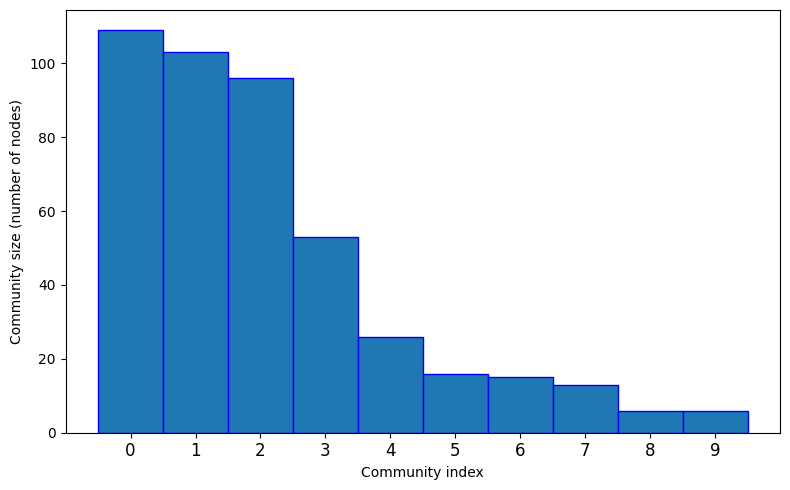

In [27]:
fig, ax = plt.subplots(figsize=(8, 5))
#fig.suptitle(r"Sizes of detected communities in best partition", size=12, y=0.955)

ax.set_ylabel('Community size (number of nodes)', size=10)
ax.set_xlabel('Community index', size=10) 

ax.bar([i for i in range(len(community_sizes))][:10], community_sizes[:10],width = 1, ec="blue", lw=1)

ax.set_xticks([i for i in range(len(community_sizes))][:10])
ax.set_xticklabels([i for i in range(len(community_sizes))][:10], size = 12)
#ax.set_xlim(0-0.5, len(community_sizes)-0.5)

#ax.set_yticks([25*i for i in range(8)])
#ax.set_yticklabels([25*i for i in range(8)][:10], size=12)

plt.tight_layout()
plt.savefig('usa_data/community_sizes.pdf', bbox_inches='tight')

Plot the communties

In [28]:
# Get the community ID for each node
community_ids = list(partition_best.values())

# print community sizes
community_sizes = list(Counter(community_ids).values())
print("Community sizes:", community_sizes)

# Define a colormap for visualizing communities
colormap = plt.cm.get_cmap("tab20", max(community_ids) + 1)

# Map community IDs to colors
node_colors = [colormap(community_id) for community_id in community_ids]

# Draw the network graph with community-based node colors
plt.figure(figsize=(7, 7))
#pos = nx.spring_layout(congress_graph_undirected, seed=42)
#nx.draw(congress_graph_undirected, pos, node_color=node_colors, with_labels=False, node_size=10)
#plt.show()

Community sizes: [96, 1, 1, 6, 1, 103, 26, 15, 1, 1, 1, 1, 53, 1, 13, 1, 1, 1, 1, 5, 1, 1, 16, 109, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


C:\Users\Nikolai\AppData\Local\Temp\ipykernel_24520\158333620.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap("tab20", max(community_ids) + 1)


<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

In [29]:
republican_count = 0
democratic_count = 0
other_count = 0
community_idx = 0
republican_democratic_community_count = []

for com in communities:
    for node in com:
        ### Append count if rapper is from West Coast
        if congress_graph_undirected.nodes[node]['party'] == 'Republican':
            republican_count += 1
            
        ### Append count if rapper is from East Coast
        elif congress_graph_undirected.nodes[node]['party'] == 'Democratic':
            democratic_count += 1

        else:
            other_count += 1
    
    ### Append community index, count of West Coast-rappers and count of East Coast-rappers to community_count
    republican_democratic_community_count.append((community_idx, republican_count, democratic_count, other_count))
    
    ### Reset counts and update index
    republican_count = 0
    democratic_count = 0
    other_count = 0
    community_idx += 1

#for v in republican_democratic_community_count:
#    print(f'Community {v[0]} has {v[1]} Republicans, and {v[2]} Democrats and {v[3]} other')

In [30]:
senators_count = 0
representatives_count = 0
community_idx = 0
senators_representatices_community_count = []

for com in communities:
    for node in com:
        ### Append count if rapper is from West Coast
        if node in senators_names:
            senators_count += 1
            
        ### Append count if rapper is from East Coast
        elif node in representatives:
            representatives_count += 1
    
    ### Append community index, count of West Coast-rappers and count of East Coast-rappers to community_count
    senators_representatices_community_count.append((community_idx, senators_count, representatives_count))
    
    ### Reset counts and update index
    senators_count = 0
    representatives_count = 0
    community_idx += 1

#for v in senators_representatices_community_count:
#    print(f'Community {v[0]} has {v[1]} senators and {v[2]} representatives')

In [31]:
sorted_partition = sorted(partition_best, key=len, reverse=True)

In [32]:
congress_graph_undirected_new = congress_graph_undirected.copy()
# remove isolated nodes
congress_graph_undirected_new.remove_nodes_from(list(nx.isolates(congress_graph_undirected_new)))

# Create a list of colors for node visualization based on the 'coast' attribute
node_colors = ["red" if congress_graph_undirected_new.nodes[node]["party"] == "Republican" else "blue" if congress_graph_undirected_new.nodes[node]["party"] == "Democratic" else "yellow" for node in congress_graph_undirected_new.nodes()]


#nx.draw(congress_graph_undirected_new, node_color = node_colors, with_labels=False, node_size=8, edge_color='gray', alpha=0.4)

In [33]:
node_colors = ["red" if congress_graph_undirected.nodes[node]["party"] == "Republican" else "blue" if congress_graph_undirected.nodes[node]["party"] == "Democratic" else "yellow" for node in congress_graph_undirected.nodes()]
#nx.draw(congress_graph_undirected, node_color = node_colors, with_labels=False, node_size=8, edge_color='gray', alpha=0.4)


How many outliers are republicans or democrats?

In [34]:
republican_count_total = 0
democratic_count_total = 0
other_count_total = 0

for v in republican_democratic_community_count[11:]:
    republican_count_total += v[1]
    democratic_count_total += v[2]
    other_count_total += v[3]

print(f'Total Republicans: {republican_count_total}')
print(f'Total Democrats: {democratic_count_total}')
print(f'Total other: {other_count_total}')


Total Republicans: 58
Total Democrats: 28
Total other: 0


In [35]:
total_republican_count = 0
total_democratic_count = 0
total_other_count = 0
total_age_republican = 0
total_age_democratic = 0
total_age_other = 0

for com in communities[11:]:  # Iterate over the last 80 communities
    republican_count = 0
    democratic_count = 0
    other_count = 0
    
    for node in com:
        # Check the party and accumulate counts and ages
        if congress_graph_undirected.nodes[node]['party'] == 'Republican':
            republican_count += 1
            try:
                total_age_republican += house_df[house_df['Member'] == node]['Age'].values[0]
            except:
                total_age_republican += senate_df[senate_df['Senator'] == node]['Age'].values[0]
        elif congress_graph_undirected.nodes[node]['party'] == 'Democratic':
            democratic_count += 1
            try:
                total_age_democratic += house_df[house_df['Member'] == node]['Age'].values[0]
            except:
                total_age_democratic += senate_df[senate_df['Senator'] == node]['Age'].values[0]
        else:
            other_count += 1
            try:
                total_age_other += house_df[house_df['Member'] == node]['Age'].values[0]
            except:
                total_age_other += senate_df[senate_df['Senator'] == node]['Age'].values[0]

    # Accumulate counts for each community
    total_republican_count += republican_count
    total_democratic_count += democratic_count
    total_other_count += other_count

# Calculate overall average age for Republicans and Democrats
avg_age_republican = total_age_republican / total_republican_count if total_republican_count > 0 else 0
avg_age_democratic = total_age_democratic / total_democratic_count if total_democratic_count > 0 else 0
avg_age_other = total_age_other / total_other_count if total_other_count > 0 else 0

# Print the results
print(f'Overall Average Age of Republicans: {avg_age_republican:.2f}')
print(f'Overall Average Age of Democrats: {avg_age_democratic:.2f}')
print(f'Overall Average Age of Others: {avg_age_other:.2f}')


Overall Average Age of Republicans: 58.52
Overall Average Age of Democrats: 59.89
Overall Average Age of Others: 0.00


In [36]:
# general age average

# print the average age of republican politicians
print("Average age of republicans")
print(senate_df[senate_df['Party'] == 'Republican']['Age'].mean())
print(house_df[house_df['Party'] == 'Republican']['Age'].mean())

# print the average age of democratic politicians
print("Average age of democrats")
print(senate_df[senate_df['Party'] == 'Democratic']['Age'].mean())
print(house_df[house_df['Party'] == 'Democratic']['Age'].mean())

# print the average age of other politicians # only in senate
print("Average age of other (senate only)")
print(senate_df[(senate_df['Party'] != 'Democratic') & (senate_df['Party'] != 'Republican')]['Age'].mean())

Average age of republicans
63.16326530612245
56.99547511312217
Average age of democrats
64.6304347826087
58.413145539906104
Average age of other (senate only)
67.2


In [37]:
total_republican_count = 0
total_democratic_count = 0
total_age_republican = 0
total_age_democratic = 0

for com in communities[:10]:  # Iterate over the last 80 communities
    republican_count = 0
    democratic_count = 0
    
    for node in com:
        # Check the party and accumulate counts and ages
        if congress_graph_undirected.nodes[node]['party'] == 'Republican':
            republican_count += 1
            try:
                total_age_republican += house_df[house_df['Member'] == node]['Age'].values[0]
            except:
                total_age_republican += senate_df[senate_df['Senator'] == node]['Age'].values[0]
        elif congress_graph_undirected.nodes[node]['party'] == 'Democratic':
            democratic_count += 1
            try:
                total_age_democratic += house_df[house_df['Member'] == node]['Age'].values[0]
            except:
                total_age_democratic += senate_df[senate_df['Senator'] == node]['Age'].values[0]

    # Accumulate counts for each community
    total_republican_count += republican_count
    total_democratic_count += democratic_count

# Calculate overall average age for Republicans and Democrats
avg_age_republican = total_age_republican / total_republican_count if total_republican_count > 0 else 0
avg_age_democratic = total_age_democratic / total_democratic_count if total_democratic_count > 0 else 0

# Print the results
print(f'Overall Average Age of Republicans: {avg_age_republican:.2f}')
print(f'Overall Average Age of Democrats: {avg_age_democratic:.2f}')


Overall Average Age of Republicans: 58.07
Overall Average Age of Democrats: 59.72


## 2.4 Split by party 

### 2.4.1 Senate + House 

In [38]:
# Divide the nodes into two communities based on the coast attribute
# Create a set of nodes from the east coast and west coast based on the CSV files for east coast rappers and west coast rappers
all_names = representatives + senators_names

congress_communties = {}

for node in congress_graph_undirected.nodes():
    party = congress_graph_undirected.nodes[node]['party']

    if party == 'Republican':
        congress_communties[node] = 1
    elif party == 'Democratic':
        congress_communties[node] = 0
    else:
        congress_communties[node] = 2

modularity_congress_parties = community.modularity(congress_communties, congress_graph_undirected)
print(f"Modularity of republican, democratic and other split: {modularity_congress_parties: .3f}")

Modularity of republican, democratic and other split:  0.169


### 2.4.2 House party 

In [39]:
# Divide the nodes into two communities based on the coast attribute
# Create a set of nodes from the east coast and west coast based on the CSV files for east coast rappers and west coast rappers
df_house = pd.read_csv("usa_data/representatives.csv")

house_communities = {}

# Getting the data
republican_house_nodes = df_house[df_house["Party"]=="Republican"]["Member"].tolist()
democratic_house_nodes = df_house[df_house["Party"]=="Democratic"]["Member"].tolist()
other_house_nodes = df_house[(df_house["Party"]!="Democratic") & (df_house["Party"]!="Republican")]["Member"].tolist()

house_subgraph = congress_graph_undirected.subgraph(representatives)

for node in house_subgraph.nodes():
        if node in republican_house_nodes:
            house_communities[node] = 1
        elif node in democratic_house_nodes:
            house_communities[node] = 0
        else:
            house_communities[node] = 2

modularity_value1 = community.modularity(house_communities, house_subgraph)
print(f"Modularity of republican, democratic other split: {modularity_value1: .3f}")

Modularity of republican, democratic other split:  0.165


### 2.4.3 Senate party 

In [40]:
df_senate = pd.read_csv("usa_data/senators.csv")
senate_communities = {}

republican_senate_nodes = df_senate[df_senate["Party"]=="Republican"]["Senator"].tolist()
democratic_senate_nodes = df_senate[df_senate["Party"]=="Democratic"]["Senator"].tolist()
other_senate_nodes = df_senate[(df_senate["Party"]!="Democratic") & (df_senate["Party"]!="Republican")]["Senator"].tolist()

senate_subgraph = congress_graph_undirected.subgraph(senators)

for node in senate_subgraph.nodes():
        if node in republican_senate_nodes:
            senate_communities[node] = 1
        elif node in democratic_senate_nodes:
            senate_communities[node] = 0
        else:
            senate_communities[node] = 2

modularity_value1 = community.modularity(senate_communities, senate_subgraph)
print(f"Modularity of republican, democratic other split: {modularity_value1: .3f}")

Modularity of republican, democratic other split:  0.124


## 2.5 Split by chamber (house or senate) 

In [41]:
# Initialize an empty partition dictionary
congress_chamber_partition = {}

# Assign all nodes from house_df to group 0
for node in representatives:
    congress_chamber_partition[node] = 0

# Assign all nodes from senate_df to group 1
for node in senators:
    congress_chamber_partition[node] = 1

modularity_value3 = community.modularity(congress_chamber_partition, congress_graph_undirected)
print(f"Modularity of house and senators split: {modularity_value3: .3f}")

Modularity of house and senators split:  0.320


## 2.6 Split by degree of education 

In [42]:
degree_communities_partition = {}
community_counter = 0
for k, v in degrees_dict.items():
    for name in v:
        degree_communities_partition[name] = int(community_counter)
    community_counter += 1

print(degree_communities_partition)
modularity_degree = community.modularity(degree_communities_partition, congress_graph_undirected)

print(f"Modularity value: {modularity_degree:.4f}")

{'Cori Bush': 0, 'Sara Jacobs': 1, 'Brad Wenstrup': 2, 'Jen Kiggans': 3, 'Jacky Rosen': 4, 'Markwayne Mullin': 4, 'Emanuel Cleaver': 5, 'James Lankford': 5, 'Brian Mast': 6, 'Josh Harder': 7, 'Jimmy Gomez': 7, 'Seth Moulton': 7, 'Brendan Boyle': 7, 'John Fetterman': 7, 'Judy Chu': 8, 'Robin Kelly': 8, 'Danny K. Davis': 8, 'Bill Foster': 8, 'Jim Baird': 8, 'Julia Letlow': 8, 'Shri Thanedar': 8, 'Dina Titus': 8, 'Alma Adams': 8, 'Tom Cole': 8, 'Rob Wittman': 8, 'Derek Kilmer': 8, 'Mike Gallagher': 8, 'Raphael Warnock': 8, 'Tammy Duckworth': 8, 'Jerry Carl': 9, 'Mary Peltola': 9, 'Eli Crane': 9, 'Juan Ciscomani': 9, 'Anna Eshoo': 9, 'David Valadao': 9, 'Grace Napolitano': 9, 'Lauren Boebert': 9, 'Bill Posey': 9, 'Mike Bost': 9, 'Clay Higgins': 9, 'Garret Graves': 9, 'Ayanna Pressley': 9, 'Matt Rosendale': 9, 'Donald Norcross': 9, 'Donald Payne Jr.': 9, 'Vacant': 9, 'Yvette Clarke': 9, 'Ritchie Torres': 9, 'Chuck Edwards': 9, 'Troy Balderson': 9, 'Lloyd Smucker': 9, 'Bruce Westerman': 10, 

In [43]:
institutions_communities = {}
community_counter = 0
for k, v in institutions_dict.items():
    for name in v:
        institutions_communities[name] = community_counter
    community_counter += 1

print(institutions_communities)
modularity_institution = community.modularity(institutions_communities, congress_graph_undirected)

print(f"Modularity value: {modularity_institution:.4f}")

{'Ron Estes': 0, 'Julia Brownley': 1, 'Jim McGovern': 1, 'Haley Stevens': 1, 'Bill Huizenga': 2, 'Sara Jacobs': 3, 'Rosa DeLauro': 3, 'Elissa Slotkin': 3, 'Greg Stanton': 4, 'Kathy Manning': 4, 'Claudia Tenney': 5, 'Joyce Beatty': 5, 'Steve Scalise': 6, 'Clay Higgins': 6, 'Mike Johnson': 6, 'Bill Cassidy': 6, 'Thomas Kean Jr.': 7, 'Rashida Tlaib': 8, 'Bob Latta': 9, 'Jonathan Jackson': 10, 'Brad Schneider': 10, 'Blake Moore': 10, 'Pramila Jayapal': 10, 'John Hoeven': 10, 'Richard Neal': 11, 'Steve Womack': 12, 'Don Davis': 13, 'Joni Ernst': 14, 'Derrick Van Orden': 15, 'Tammy Baldwin': 16, 'Cliff Bentz': 17, 'Marilyn Strickland': 18, 'Garret Graves': 19, 'Tom Tiffany': 20, 'Ilhan Omar': 21, 'Chris Smith': 22, 'Lauren Underwood': 23, 'Andy Harris': 23, 'Kweisi Mfume': 23, 'Lisa Blunt Rochester': 24, 'Tom Carper': 24, 'Jake Ellzey': 25, 'Ralph Norman': 26, 'Teresa Leger Fernandez': 27, 'Dan Goldman': 27, 'Ronny Jackson': 28, 'Ken Buck': 29, 'Harriet Hageman': 29, 'Cynthia Lummis': 29, 'T

# 3 Community strength 


In [44]:
def community_stats(partition, graph):
    # get list of communities
    community_keys = list(set(partition.values()))

    # create dictionary with community id as key and list of nodes as values
    community_ext = dict()
    community_int = dict()
    community_m_c = dict()

    L = len(graph.edges())
    # investigate number of internal and external links in each community
    for idx in community_keys:

        ext_counter = 0
        int_counter = 0

        # make list of nodes in community
        community_nodes = [node for node in graph.nodes() if partition[node] == idx]
        L_c = len(graph.subgraph(community_nodes).edges())
        
        # find total degree of nodes in community
        k_c = 0
        for node in community_nodes:
        # find external links
            k_c += graph.degree(node)
            edges = graph.edges(node)
            
            for edge in edges:
                if partition[edge[0]] != partition[edge[1]]:
                    ext_counter += 1
                else:
                    int_counter += 1
            
        community_ext[idx] = ext_counter
        community_int[idx] = int_counter
        community_m_c[idx] = L_c/L-((k_c/(2*L))**2)

    # create dataframe with community id, number of nodes, number of internal links, number of external links
    community_df = pd.DataFrame()

    for idx in community_keys:
        new_row = pd.DataFrame([[idx, 
                                len([node for node in graph.nodes() if partition[node] == idx]),
                                community_int[idx],
                                community_ext[idx],
                                # add a row to determine if the community is strong or weak
                                community_int[idx] > community_ext[idx], 
                                community_m_c[idx]
                                ]])
        community_df = pd.concat([community_df,new_row], axis = 0, ignore_index=True)

    community_df.columns = ['Community ID', 'Number of nodes', 'Number of internal links', 'Number of external links', 'Strength','M_c']
    return community_df

## 3.1 All partitions 

In [45]:
# remove sekf loops
#congress_graph.remove_edges_from(nx.selfloop_edges(congress_graph))

# Best partition
df = community_stats(partition_best, congress_graph_undirected)
modularity_best = df['M_c']
df = df[df["Number of nodes"]>3]
print(df['M_c'])
print(sum(df['M_c']))

# find mean and std of modularity
print(f"Mean modularity: {df['M_c'].mean():.4f}")
print(f"Std modularity: {df['M_c'].std():.4f}")

# compare to modularity of partition
print(f"Modularity of partition: {community.modularity(partition_best, congress_graph_undirected):.4f}")

# sum the number of strong communities
print(" The  number of strong communities is: " , df['Strength'].sum())

# sum the number of weak communities
#community_stats(partition_best, congress_graph)['Strength'].count() - community_stats(partition_best, congress_graph)['Strength'].sum()
print(" The  number of weak communities is: " ,df['Strength'].count() - df['Strength'].sum())


0     0.082442
3     0.002387
5     0.085715
6     0.014192
13    0.047739
16    0.005673
19    0.007010
22    0.001914
26    0.165148
35    0.007531
42    0.002387
Name: M_c, dtype: float64
0.4221380362216205
Mean modularity: 0.0384
Std modularity: 0.0528
Modularity of partition: 0.4236
 The  number of strong communities is:  10
 The  number of weak communities is:  1


In [46]:
# Party partition
df = community_stats(congress_communties, congress_graph_undirected)
modularity_party = df['M_c']
print(df['M_c'])
#print(df)

# Print the name member of community 0

# sum the number of strong communities
print(" The  number of strong communities is: " , df['Strength'].sum())

# sum the number of weak communities
print(" The  number of weak communities is: " , df['Strength'].count() - df['Strength'].sum())


0    0.079042
1    0.088537
2    0.001138
Name: M_c, dtype: float64
 The  number of strong communities is:  2
 The  number of weak communities is:  1


In [47]:
# House party partition
df = community_stats(house_communities, house_subgraph)
modularity_house_party = df['M_c'] 
print(df['M_c'])

#print(df)

# sum the number of strong communities
print(" The  number of strong communities is: " , df['Strength'].sum())

# sum the number of weak communities
print(" The  number of weak communities is: " , df['Strength'].count() - df['Strength'].sum())

0    0.077710
1    0.086220
2    0.001118
Name: M_c, dtype: float64
 The  number of strong communities is:  2
 The  number of weak communities is:  1


In [48]:
# Senate party partition
df = community_stats(senate_communities, senate_subgraph)
modularity_senate_party = df['M_c']
print(df['M_c'])
#print(df)

# sum the number of strong communities
print(" The  number of strong communities is: " , df['Strength'].sum())

# sum the number of weak communities
print(" The  number of weak communities is: " , df['Strength'].count() - df['Strength'].sum())

0    0.050898
1    0.072033
2    0.000685
Name: M_c, dtype: float64
 The  number of strong communities is:  2
 The  number of weak communities is:  1


In [49]:
# chamber partition
df_chamber = community_stats(congress_chamber_partition, congress_graph_undirected)
modularity_chamber = df_chamber['M_c']
print(df_chamber['M_c'])
#print(df)
print(community.modularity(congress_chamber_partition, congress_graph_undirected))

# print congress chamber partition
print("Congress chamber partition")


# sum the number of strong communities
print(" The  number of strong communities is: " ,df_chamber['Strength'].sum())

# sum the number of weak communities
print(" The  number of weak communities is: " , df_chamber['Strength'].count() - df_chamber['Strength'].sum())

0    0.160217
1    0.160217
Name: M_c, dtype: float64
0.3204333218158794
Congress chamber partition
 The  number of strong communities is:  2
 The  number of weak communities is:  0


In [50]:
print(degree_communities_partition)

{'Cori Bush': 0, 'Sara Jacobs': 1, 'Brad Wenstrup': 2, 'Jen Kiggans': 3, 'Jacky Rosen': 4, 'Markwayne Mullin': 4, 'Emanuel Cleaver': 5, 'James Lankford': 5, 'Brian Mast': 6, 'Josh Harder': 7, 'Jimmy Gomez': 7, 'Seth Moulton': 7, 'Brendan Boyle': 7, 'John Fetterman': 7, 'Judy Chu': 8, 'Robin Kelly': 8, 'Danny K. Davis': 8, 'Bill Foster': 8, 'Jim Baird': 8, 'Julia Letlow': 8, 'Shri Thanedar': 8, 'Dina Titus': 8, 'Alma Adams': 8, 'Tom Cole': 8, 'Rob Wittman': 8, 'Derek Kilmer': 8, 'Mike Gallagher': 8, 'Raphael Warnock': 8, 'Tammy Duckworth': 8, 'Jerry Carl': 9, 'Mary Peltola': 9, 'Eli Crane': 9, 'Juan Ciscomani': 9, 'Anna Eshoo': 9, 'David Valadao': 9, 'Grace Napolitano': 9, 'Lauren Boebert': 9, 'Bill Posey': 9, 'Mike Bost': 9, 'Clay Higgins': 9, 'Garret Graves': 9, 'Ayanna Pressley': 9, 'Matt Rosendale': 9, 'Donald Norcross': 9, 'Donald Payne Jr.': 9, 'Vacant': 9, 'Yvette Clarke': 9, 'Ritchie Torres': 9, 'Chuck Edwards': 9, 'Troy Balderson': 9, 'Lloyd Smucker': 9, 'Bruce Westerman': 10, 

In [51]:
# Degree partition
df_degree = community_stats(degree_communities_partition, congress_graph_undirected)
modularity_degree = df_degree['M_c']

#df_degree = df_degree[df_degree["Number of nodes"]>0]
#print(df)

df_degree = df_degree.sort_values(by=['Number of internal links'], ascending=False)
print(df_degree.head(10))
print(f"Modularity of partition: {community.modularity(degree_communities_partition, congress_graph_undirected):.4f}")

# print keys where the value is 27 in degree_communities_partition
print([k for k, v in degree_communities_partition.items() if v == 27])

# find mean and std of modularity
print(f"Mean modularity: {df_degree['M_c'].mean():.4f}")
print(f"Std modularity: {df_degree['M_c'].std():.4f}")

# sum the number of strong communities
print(" The  number of strong communities is: " , df_degree['Strength'].sum())

# sum the number of weak communities
print(" The  number of weak communities is: " , df_degree['Strength'].count() - df_degree['Strength'].sum())

    Community ID  Number of nodes  Number of internal links  \
36            36              168                       714   
43            43               81                       122   
27            27               61                        36   
32            32               45                        30   
31            31               35                        20   
40            40                5                         4   
10            10               22                         4   
26            26               17                         2   
8              8               15                         2   
9              9               21                         2   

    Number of external links  Strength       M_c  
36                       886     False  0.023586  
43                       539     False  0.004059  
27                       280     False  0.002881  
32                       343     False -0.000837  
31                       182     False  0.002450  


In [52]:
# Institution partition
df_institution = community_stats(institutions_communities, congress_graph_undirected)
modularity_institution = df_institution['M_c']

# sort the dataframe by number of nodes
df_institution = df_institution.sort_values(by=['Number of internal links'], ascending=False)

# sum the number of strong communities
print(" The  number of strong communities is: " , df_institution['Strength'].sum())

# sum the number of weak communities
print(" The  number of weak communities is: " , df_institution['Strength'].count() - df_institution['Strength'].sum())

 The  number of strong communities is:  0
 The  number of weak communities is:  318


# 4 Wordclouds 

## 4.1 Preprocessing 

In [53]:
# directories
senators_directory = 'usa_data/senate/'
representatives_directory = 'usa_data/house/'

In [54]:
# concatenate all the names
all_politician_names = senators + representatives

# divide each name  into token
all_politician_names = [p.split(" ") for p in all_politician_names]

# clean the names
all_politician_names = [item for sublist in all_politician_names for item in sublist]
all_politician_names = [p.lower() for p in all_politician_names]

print(all_politician_names)

['tommy', 'tuberville', 'katie', 'britt', 'lisa', 'murkowski', 'dan', 'sullivan', 'kyrsten', 'sinema', 'mark', 'kelly', 'john', 'boozman', 'tom', 'cotton', 'alex', 'padilla', 'laphonza', 'butler', 'michael', 'bennet', 'john', 'hickenlooper', 'richard', 'blumenthal', 'chris', 'murphy', 'tom', 'carper', 'chris', 'coons', 'marco', 'rubio', 'rick', 'scott', 'jon', 'ossoff', 'raphael', 'warnock', 'brian', 'schatz', 'mazie', 'hirono', 'mike', 'crapo', 'jim', 'risch', 'dick', 'durbin', 'tammy', 'duckworth', 'todd', 'young', 'mike', 'braun', 'chuck', 'grassley', 'joni', 'ernst', 'jerry', 'moran', 'roger', 'marshall', 'mitch', 'mcconnell', 'rand', 'paul', 'bill', 'cassidy', 'john', 'kennedy', 'susan', 'collins', 'angus', 'king', 'ben', 'cardin', 'chris', 'van', 'hollen', 'elizabeth', 'warren', 'ed', 'markey', 'debbie', 'stabenow', 'gary', 'peters', 'amy', 'klobuchar', 'tina', 'smith', 'roger', 'wicker', 'cindy', 'hyde-smith', 'josh', 'hawley', 'eric', 'schmitt', 'jon', 'tester', 'steve', 'daine

In [55]:
# Download NLTK stopwords data (do this once)
nltk.download('stopwords')

# Get English stopwords
stop_words = set(stopwords.words('english'))

def cleaned_politician_texts(text, politician_names):
    if not isinstance(text, str):
        return []  # Return an empty list if text is not a string

    # remove all .
    text = text.replace(".", " ")
    
    tokens = word_tokenize(text)
    clean_tokens = []

    for token in tokens:
        # Convert to lowercase
        token = unidecode(token.lower())
        
        # Remove punctuation, stopwords, and politician names
        if (token not in string.punctuation) and (token not in stop_words) and (token not in all_politician_names):
            clean_tokens.append(token)

    return clean_tokens

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nikolai\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 4.2 Best partition 

In [56]:
politician_communities = {politician: community_id for politician, community_id in partition_best.items()}

# remove punctuation from politican keys in politician_communities
politician_communities = {k.replace(".",""): v for k, v in politician_communities.items()}

# Create a nested dictionary. Outer key is the community id and the inner key is the politicians name.
#Each inner value will be a list of cleaned tokens
community_politicians_tokens = defaultdict(lambda: defaultdict(list))

# Load texts for senators
for filename in os.listdir(senators_directory):
    if filename.endswith('.txt'):
        politician_name = os.path.splitext(filename)[0]  # Remove the '.txt' extension
        file_path = os.path.join(senators_directory, filename)
        
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()
            file.close()
        cleaned_text = cleaned_politician_texts(text, all_politician_names)
        # Get the community ID for the politician
        community_id = politician_communities.get(politician_name)

        if community_id is None:
            print(f'No community found for {politician_name}')
        # Store the cleaned tokens under the corresponding community and politician
        community_politicians_tokens[community_id][politician_name].extend(cleaned_text)

# Load texts for representatives
for filename in os.listdir(representatives_directory):
    if filename.endswith('.txt'):
        politician_name = os.path.splitext(filename)[0]  # Remove the '.txt' extension
        file_path = os.path.join(representatives_directory, filename)
        
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()
            file.close()

        cleaned_text = cleaned_politician_texts(text, all_politician_names)
        
        community_id = politician_communities.get(politician_name)

        if community_id is None:
            print(f'No community found for {politician_name}')
            
        # Store the cleaned tokens under the corresponding community and politician
        community_politicians_tokens[community_id][politician_name].extend(cleaned_text)

In [58]:
# Create a dictionary to store frequency lists for each community
community_frequency_lists = defaultdict(dict)

# Create frequency lists for each community
for community, politicians in community_politicians_tokens.items():
    aggregated_tokens = [token for tokens in politicians.values() for token in tokens]
    frequency_list = Counter(aggregated_tokens)
    community_frequency_lists[community] = frequency_list


In [59]:
# Create a dictionary to store ratio lists for each community
community_ratio_lists = defaultdict(dict)

# Add a constant to avoid division by zero
constant = 1

# Calculate ratio lists for each community
for current_community, current_frequency_list in community_frequency_lists.items():
    other_communities = [c for c in community_frequency_lists if c != current_community]

    for word, frequency in current_frequency_list.items():
        total_frequency_other_communities = sum(community_frequency_lists[c][word] for c in other_communities) + constant
        ratio = frequency / total_frequency_other_communities

        # Store the ratio for the word in the current community
        community_ratio_lists[current_community][word] = ratio


In [60]:
# Function to create and display word clouds for each community
def generate_wordclouds(community_ratio_lists, output_directory='wordclouds'):
    # Create the output directory if it doesn't exist
    os.makedirs(output_directory, exist_ok=True)

    for community, ratio_list in community_ratio_lists.items():
        if community == "N/A":
            continue

        # Sort the ratio list by value in descending order
        sorted_ratio_list = sorted(ratio_list.items(), key=lambda x: x[1], reverse=True)

        # Create a WordCloud object
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(sorted_ratio_list))

        # Plot the WordCloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Best Partition Word Cloud for Community {community}')
        plt.axis('off')

        # Save the plot
        save_path = os.path.join(r"wordclouds", f'Best Partition Wordcloud_community_{community}.png')
        print(save_path)
        plt.savefig(save_path, bbox_inches='tight')

        # Show the plot
        plt.show()

# Generate and display word clouds for each community
#generate_wordclouds(community_ratio_lists)

## 4.3 WordClouds for House vs. Senators 

In [61]:
house_vs_sen_communities = {politician: community_id for politician, community_id in congress_chamber_partition.items()}
house_vs_sen_communities = {k.replace(".",""): v for k, v in house_vs_sen_communities.items()}

print(house_vs_sen_communities)

{'Jerry Carl': 0, 'Barry Moore': 0, 'Mike Rogers': 0, 'Robert Aderholt': 0, 'Dale Strong': 0, 'Gary Palmer': 0, 'Terri Sewell': 0, 'Mary Peltola': 0, 'David Schweikert': 0, 'Eli Crane': 0, 'Ruben Gallego': 0, 'Greg Stanton': 0, 'Andy Biggs': 0, 'Juan Ciscomani': 0, 'Raul Grijalva': 0, 'Debbie Lesko': 0, 'Paul Gosar': 0, 'Rick Crawford': 0, 'French Hill': 0, 'Steve Womack': 0, 'Bruce Westerman': 0, 'Doug LaMalfa': 0, 'Jared Huffman': 0, 'Kevin Kiley': 0, 'Mike Thompson': 0, 'Tom McClintock': 0, 'Ami Bera': 0, 'Doris Matsui': 0, 'John Garamendi': 0, 'Josh Harder': 0, 'Mark DeSaulnier': 0, 'Nancy Pelosi': 0, 'Barbara Lee': 0, 'John Duarte': 0, 'Eric Swalwell': 0, 'Kevin Mullin': 0, 'Anna Eshoo': 0, 'Ro Khanna': 0, 'Zoe Lofgren': 0, 'Jimmy Panetta': 0, 'Kevin McCarthy': 0, 'Jim Costa': 0, 'David Valadao': 0, 'Jay Obernolte': 0, 'Salud Carbajal': 0, 'Raul Ruiz': 0, 'Julia Brownley': 0, 'Mike Garcia': 0, 'Judy Chu': 0, 'Tony Cardenas': 0, 'Adam Schiff': 0, 'Grace Napolitano': 0, 'Brad Sherma

In [62]:
# Create a nested dictionary. Outer key is the community id and the inner key is the politicians name.
#Each inner value will be a list of cleaned tokens
house_vs_sen_tokens = defaultdict(lambda: defaultdict(list))

# Load texts for senators
for filename in os.listdir(senators_directory):
    if filename.endswith('.txt'):
        politician_name = os.path.splitext(filename)[0]  # Remove the '.txt' extension
        file_path = os.path.join(senators_directory, filename)

        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()
            file.close()
        
        cleaned_text = cleaned_politician_texts(text, all_politician_names)

        # Get the community ID for the politician            
        #community_id = house_vs_sen_communities.get(politician_name)
        community_id = "senate"

        if community_id is None:
            print(f'No community found for {politician_name}. Skipping...')
        # Store the cleaned tokens under the corresponding community and politician
        house_vs_sen_tokens[community_id][politician_name].extend(cleaned_text)

# Load texts for representatives
for filename in os.listdir(representatives_directory):
    if filename.endswith('.txt'):
        politician_name = os.path.splitext(filename)[0]  # Remove the '.txt' extension
        file_path = os.path.join(representatives_directory, filename)
        
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()
            file.close()
            
        cleaned_text = cleaned_politician_texts(text, all_politician_names)            

        #community_id = house_vs_sen_communities.get(politician_name)
        community_id = "house"
        
        if community_id is None:
            print(f'No community found for {politician_name}. Skipping...')

        # Store the cleaned tokens under the corresponding community and politician
        house_vs_sen_tokens[community_id][politician_name].extend(cleaned_text)


In [64]:
# Create a dictionary to store frequency lists for each community
community_frequency_lists2 = defaultdict(dict)

# Create frequency lists for each community
for community, politicians in house_vs_sen_tokens.items():
    aggregated_tokens = [token for tokens in politicians.values() for token in tokens]
    frequency_list2 = Counter(aggregated_tokens)
    community_frequency_lists2[community] = frequency_list2

# Print community_frequency_lists 
for community, frequency_list2 in community_frequency_lists2.items():
    print(f'Community: {community}, Frequency List: {frequency_list2}')

Community: senate, Frequency List: Counter({'``': 5849, "'s": 4534, '===': 3374, "''": 3020, 'senate': 2355, '==': 2098, 'would': 1662, 'u': 1660, 'states': 1493, '====': 1456, 'trump': 1453, 'act': 1358, 'said': 1356, 'united': 1350, 'republican': 1326, 'election': 1273, 'committee': 1234, 'state': 1218, 'one': 1112, 'vote': 1022, 'democratic': 996, 'president': 983, 'senator': 978, 'federal': 940, 'campaign': 930, 'senators': 897, 'voted': 873, 'subcommittee': 860, 'also': 830, 'congress': 818, 'house': 792, '2018': 766, 'new': 754, 'first': 730, '2019': 721, 'american': 707, 'law': 704, 'health': 665, 'legislation': 653, 'national': 651, '2020': 644, 'january': 629, 'support': 617, '2016': 583, 'party': 571, 'called': 571, '2021': 569, 'governor': 566, '2017': 564, 'general': 555, 'office': 545, 'court': 543, 'care': 535, 'school': 522, 'political': 522, 'administration': 490, 'public': 474, 'two': 469, 'member': 468, 'security': 456, 'government': 456, 'may': 450, 'letter': 448, 'a

In [65]:
# Create a dictionary to store ratio lists for each community
community_ratio_lists2 = defaultdict(dict)

# Add a constant to avoid division by zero
constant = 1

# Calculate ratio lists for each community
for current_community2, current_frequency_list2 in community_frequency_lists2.items():
    other_communities2 = [c for c in community_frequency_lists2 if c != current_community2]

    for word2, frequency2 in current_frequency_list2.items():
        total_frequency_other_communities2 = sum(community_frequency_lists2[c][word2] for c in other_communities2) + constant
        ratio2 = frequency2 / total_frequency_other_communities2

        # Store the ratio for the word in the current community
        community_ratio_lists2[current_community2][word2] = ratio2

# Print community_ratio_lists
for community2, ratio_list2 in community_ratio_lists2.items():
    print(f'Community: {community2}, Ratio List: {ratio_list2}')

Community: senate, Ratio List: {'alejandro': 0.13333333333333333, '``': 0.9017884674683935, "''": 0.8594194649971543, 'born': 0.2847011144883485, 'march': 0.956989247311828, '22': 0.8623853211009175, '1973': 0.4642857142857143, 'american': 0.5540752351097179, 'politician': 0.2540650406504065, 'serving': 0.4051948051948052, 'senior': 1.509433962264151, 'united': 0.6933744221879815, 'states': 0.7233527131782945, 'senator': 2.4759493670886075, 'california': 0.12164296998420221, 'seat': 0.6592920353982301, 'held': 0.6584615384615384, 'since': 0.5651577503429356, '2021': 0.5220183486238532, 'member': 0.3723150357995227, 'democratic': 0.577391304347826, 'party': 0.6061571125265393, 'served': 0.47851335656213706, '30th': 0.21739130434782608, 'secretary': 1.1528384279475983, 'state': 0.6605206073752712, '2015': 0.8471502590673575, 'senate': 2.55700325732899, 'los': 0.21296296296296297, 'angeles': 0.2018348623853211, 'city': 0.3416815742397138, 'council': 0.42201834862385323, 'governor': 1.5174

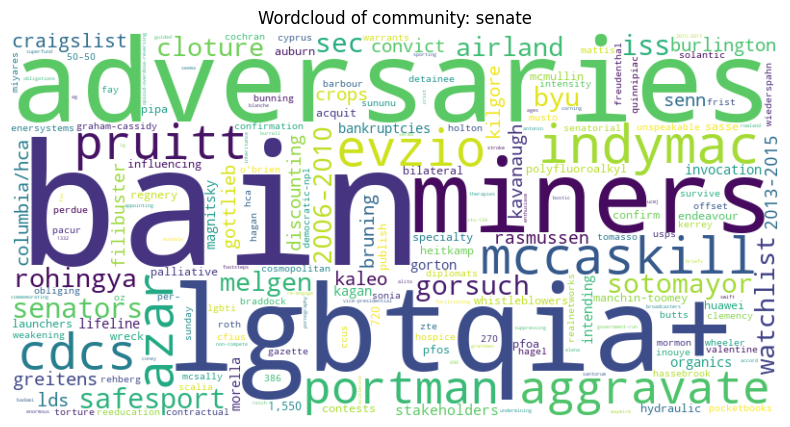

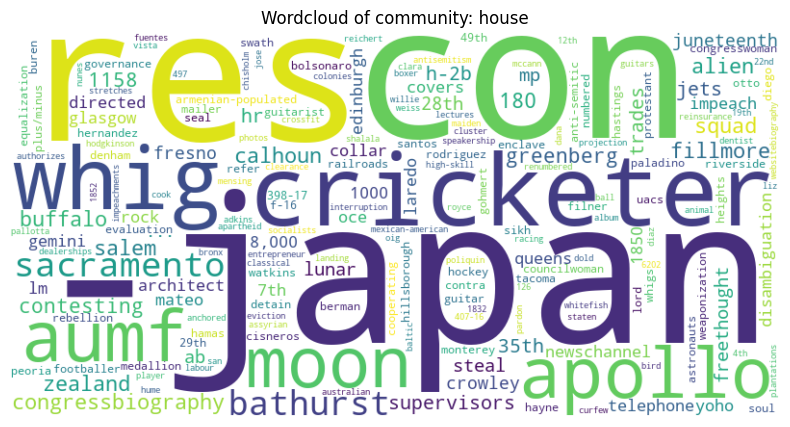

In [66]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to create and display word clouds for each community
def generate_wordclouds(community_ratio_lists2, output_directory='usa_data/wordclouds'):
    # Create the output directory if it doesn't exist
    os.makedirs(output_directory, exist_ok=True)

    for community2, ratio_list2 in community_ratio_lists2.items():
        if community2 == "N/A":
            continue

        # Sort the ratio list by value in descending order
        sorted_ratio_list2 = sorted(ratio_list2.items(), key=lambda x: x[1], reverse=True)

        # Create a WordCloud object
        wordcloud2 = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(sorted_ratio_list2))

        # Plot the WordCloud
        plt.figure(figsize=(10, 5))
        
        plt.imshow(wordcloud2, interpolation='bilinear')
        plt.title(f'Wordcloud of community: {community2}')
        plt.axis('off')

        # Save the plot
        save_path = os.path.join(output_directory, f'Wordcloud_community_{community2}.pdf')
        plt.savefig(save_path, bbox_inches='tight')

        # Show the plot
        #lt.s#how()

# Generate and display word clouds for each community
generate_wordclouds(community_ratio_lists2)

## 4.4 Party communities 


### 4.4.1 Both chambers 

In [67]:
party_communities = {politician: community_id for politician, community_id in congress_communties.items()}
party_communities = {k.replace(".",""): v for k, v in congress_communties.items()}

In [68]:
print(party_communities)

{'Jerry Carl': 1, 'Barry Moore': 1, 'Mike Rogers': 1, 'Robert Aderholt': 1, 'Dale Strong': 1, 'Gary Palmer': 1, 'Terri Sewell': 0, 'Mary Peltola': 0, 'David Schweikert': 1, 'Eli Crane': 1, 'Ruben Gallego': 0, 'Greg Stanton': 0, 'Andy Biggs': 1, 'Juan Ciscomani': 1, 'Raul Grijalva': 0, 'Debbie Lesko': 1, 'Paul Gosar': 1, 'Rick Crawford': 1, 'French Hill': 1, 'Steve Womack': 1, 'Bruce Westerman': 1, 'Doug LaMalfa': 1, 'Jared Huffman': 0, 'Kevin Kiley': 1, 'Mike Thompson': 0, 'Tom McClintock': 1, 'Ami Bera': 0, 'Doris Matsui': 0, 'John Garamendi': 0, 'Josh Harder': 0, 'Mark DeSaulnier': 0, 'Nancy Pelosi': 0, 'Barbara Lee': 0, 'John Duarte': 1, 'Eric Swalwell': 0, 'Kevin Mullin': 0, 'Anna Eshoo': 0, 'Ro Khanna': 0, 'Zoe Lofgren': 0, 'Jimmy Panetta': 0, 'Kevin McCarthy': 1, 'Jim Costa': 0, 'David Valadao': 1, 'Jay Obernolte': 1, 'Salud Carbajal': 0, 'Raul Ruiz': 0, 'Julia Brownley': 0, 'Mike Garcia': 1, 'Judy Chu': 0, 'Tony Cardenas': 0, 'Adam Schiff': 0, 'Grace Napolitano': 0, 'Brad Sherma

In [69]:
# get list of republican and democratic politicians
republicans = []
democrats = []
other = []

for i in congress_communties:
    if congress_communties[i] == 1:
        republicans.append(i)
    elif congress_communties[i] == 0:
        democrats.append(i)
    else:
        other.append(i)

In [70]:
# Create a nested dictionary. Outer key is the community id and the inner key is the politicians name.
#Each inner value will be a list of cleaned tokens
house_party_tokens = defaultdict(lambda: defaultdict(list))

# Load texts for representatives
for filename in os.listdir(representatives_directory):
    if filename.endswith('.txt'):
        politician_party_name = os.path.splitext(filename)[0]  # Remove the '.txt' extension
        file_path = os.path.join(representatives_directory, filename)
        
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()
            file.close()
            
        cleaned_text = cleaned_politician_texts(text, all_politician_names)

        # Get the community ID for the politician
        #community_id = partition.get(politician_name, "N/A")
        
        #community_id_house_party = house_party_communities.get(politician_house_party_name) 

        if politician_party_name in republicans:
            community_id_party = "republican"
        elif politician_party_name in democrats:
            community_id_party = "democrate"
        else:
            community_id_party = "other"

        # Store the cleaned tokens under the corresponding community and politician
        house_party_tokens[community_id_party][politician_party_name].extend(cleaned_text)

In [71]:
# Create a dictionary to store frequency lists for each community
community_frequency_lists_party = defaultdict(dict)

# Create frequency lists for each community
for community, politicians in house_party_tokens.items():
    aggregated_tokens_party = [token for tokens in politicians.values() for token in tokens]
    frequency_list_party = Counter(aggregated_tokens_party)
    community_frequency_lists_party[community] = frequency_list_party

In [72]:
# Create a dictionary to store ratio lists for each community
community_ratio_lists_party = defaultdict(dict)

# Add a constant to avoid division by zero
constant = 1

# Calculate ratio lists for each community
for current_community_party, current_frequency_list_party in community_frequency_lists_party.items():
    other_communities_party = [c for c in community_frequency_lists_party if c != current_community_party]

    for word_party, frequency_party in current_frequency_list_party.items():
        total_frequency_other_communities_party = sum(community_frequency_lists_party[c][word_party] for c in other_communities_party) + constant
        ratio_party = frequency_party / total_frequency_other_communities_party

        # Store the ratio for the word in the current community
        community_ratio_lists_party[current_community_party][word_party] = ratio_party

In [73]:
print(community_ratio_lists_party["other"])

{'milford': 0.5, 'jr': 0.11538461538461539, 'born': 0.01023541453428864, 'december': 0.008988764044943821, '17': 0.016, '1958': 0.041666666666666664, 'american': 0.008695652173913044, 'politician': 0.01026694045174538, 'u': 0.011115685467270481, 'representative': 0.009250693802035153, 'new': 0.030983733539891558, 'jersey': 0.27007299270072993, "'s": 0.008453350031308704, '10th': 0.03389830508474576, 'congressional': 0.011332728921124207, 'district': 0.010277883517320136, 'since': 0.009695290858725761, '2012': 0.03359683794466403, 'member': 0.012077294685990338, 'democratic': 0.014109347442680775, 'party': 0.011815252416756176, 'served': 0.012941176470588235, 'president': 0.010594947025264874, 'newark': 1.2857142857142858, 'city': 0.007207207207207207, 'council': 0.025078369905956112, '2010': 0.017341040462427744, 'following': 0.008955223880597015, 'death': 0.02027027027027027, 'father': 0.03347280334728033, 'march': 0.013071895424836602, '6': 0.024282560706401765, 'ran': 0.015452538631

usa_data/wordclouds\wordcloud_community_republican.pdf


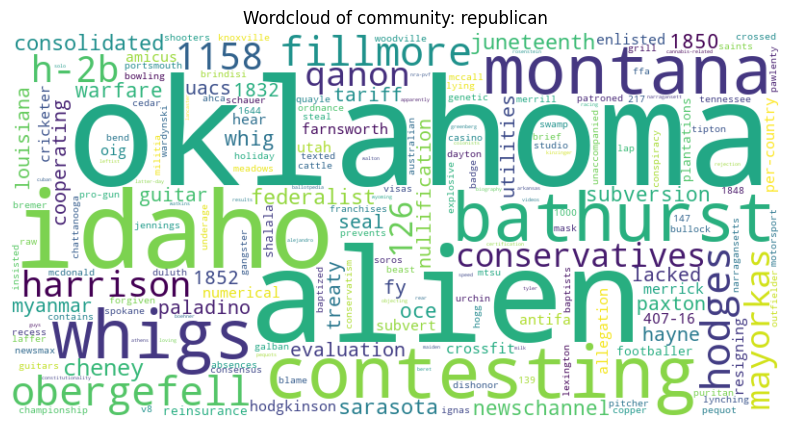

usa_data/wordclouds\wordcloud_community_democrate.pdf


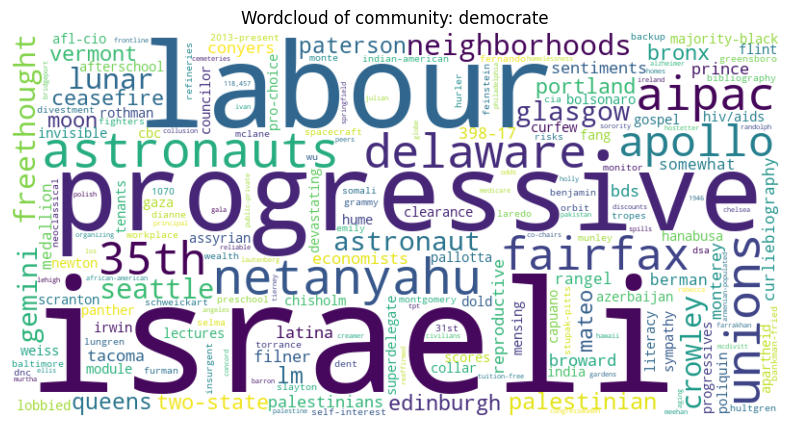

usa_data/wordclouds\wordcloud_community_other.pdf


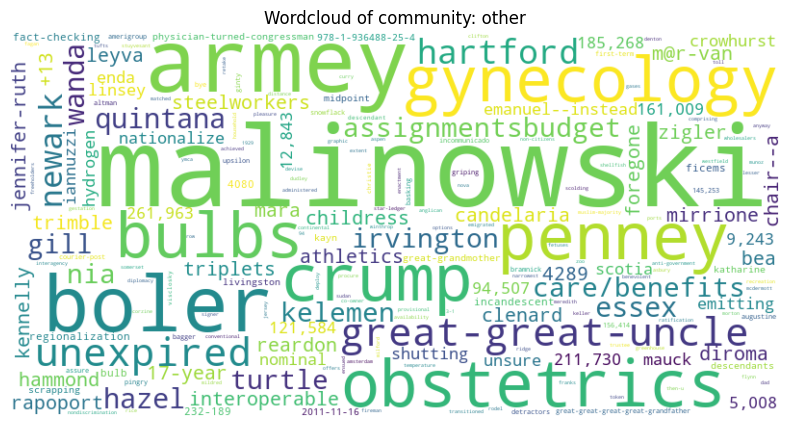

In [74]:
# Function to create and display word clouds for each community
def generate_wordclouds(community_ratio_lists_party, output_directory='usa_data/wordclouds'):
    # Create the output directory if it doesn't exist
    os.makedirs(output_directory, exist_ok=True)

    for community_party2, ratio_list_party in community_ratio_lists_party.items():

        
        # Sort the ratio list by value in descending order
        sorted_ratio_list_party2 = sorted(ratio_list_party.items(), key=lambda x: x[1], reverse=True)
        # Create a WordCloud object
        wordcloud_party = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(sorted_ratio_list_party2))

        # Plot the WordCloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud_party, interpolation='bilinear')
        plt.title(f'Wordcloud of community: {community_party2}')
        plt.axis('off')

        # Save the plot
        save_path = os.path.join(output_directory, f'wordcloud_community_{community_party2}.pdf')
        print(save_path)
        plt.savefig(save_path, bbox_inches='tight')

        # Show the plot
        plt.show()

# Generate and display word clouds for each community
generate_wordclouds(community_ratio_lists_party)

### 4.4.2 House of Representatives - Party Communities 

In [75]:
house_party_communities = {politician: community_id for politician, community_id in house_communities.items()}
house_party_communities = {k.replace(".",""): v for k, v in house_party_communities.items()}

In [76]:
# get list of republican and democratic politicians
republicans = []
democrats = []

for i in house_party_communities:
    if house_party_communities[i] == 1:
        republicans.append(i)
    else:
        democrats.append(i)

In [77]:
# Create a nested dictionary. Outer key is the community id and the inner key is the politicians name.
#Each inner value will be a list of cleaned tokens
house_party_tokens = defaultdict(lambda: defaultdict(list))

# Load texts for representatives
for filename in os.listdir(representatives_directory):
    if filename.endswith('.txt'):
        politician_house_party_name = os.path.splitext(filename)[0]  # Remove the '.txt' extension
        file_path = os.path.join(representatives_directory, filename)
        
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()
            file.close()
            
        cleaned_text = cleaned_politician_texts(text, all_politician_names)

        # Get the community ID for the politician
        #community_id = partition.get(politician_name, "N/A")
        
        #community_id_house_party = house_party_communities.get(politician_house_party_name) 

        if politician_house_party_name in republicans:
            community_id_house_party = "republican"
        elif politician_house_party_name in democrats:
            community_id_house_party = "democrate"
        else:
            community_id_house_party = "other"

        # Store the cleaned tokens under the corresponding community and politician
        house_party_tokens[community_id_house_party][politician_house_party_name].extend(cleaned_text)

In [79]:
# Create a dictionary to store frequency lists for each community
community_frequency_lists_house_party = defaultdict(dict)

# Create frequency lists for each community
for community, politicians in house_party_tokens.items():
    aggregated_tokens_house_party = [token for tokens in politicians.values() for token in tokens]
    frequency_list_house_party = Counter(aggregated_tokens_house_party)
    community_frequency_lists_house_party[community] = frequency_list_house_party

# Print community_frequency_lists 
#for community, frequency_list_house_party in community_frequency_lists_house_party.items():
#    print(f'Community: {community}, Frequency List: {frequency_list_house_party}')

In [80]:
# Create a dictionary to store ratio lists for each community
community_ratio_lists_house_party = defaultdict(dict)

# Add a constant to avoid division by zero
constant = 1

# Calculate ratio lists for each community
for current_community_house_party, current_frequency_list_house_party in community_frequency_lists_house_party.items():
    other_communities_house_party = [c for c in community_frequency_lists_house_party if c != current_community_house_party]

    for word_house_party, frequency_house_party in current_frequency_list_house_party.items():
        total_frequency_other_communities_house_party = sum(community_frequency_lists_house_party[c][word_house_party] for c in other_communities_house_party) + constant
        ratio_house_party = frequency_house_party / total_frequency_other_communities_house_party

        # Store the ratio for the word in the current community
        community_ratio_lists_house_party[current_community_house_party][word_house_party] = ratio_house_party

# Print community_ratio_lists
#for community_house_party2, ratio_list_house_party in community_ratio_lists_house_party.items():
#    print(f'Community: {community_house_party2}, Ratio List: {ratio_list_house_party}')

usa_data/wordclouds\House_party_Wordcloud_community_republican.png


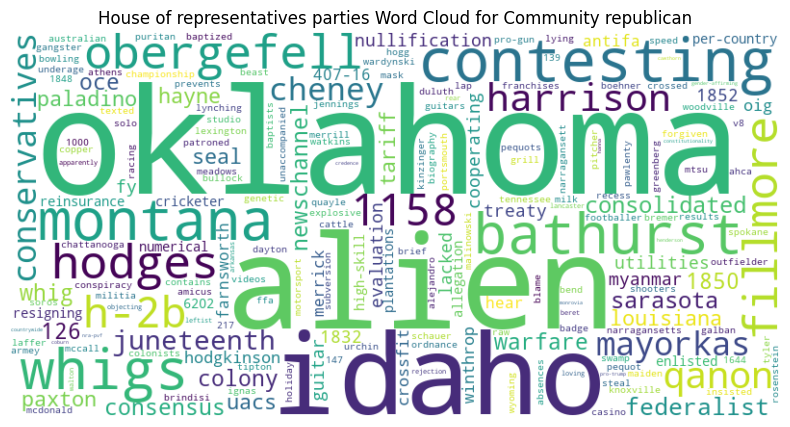

usa_data/wordclouds\House_party_Wordcloud_community_democrate.png


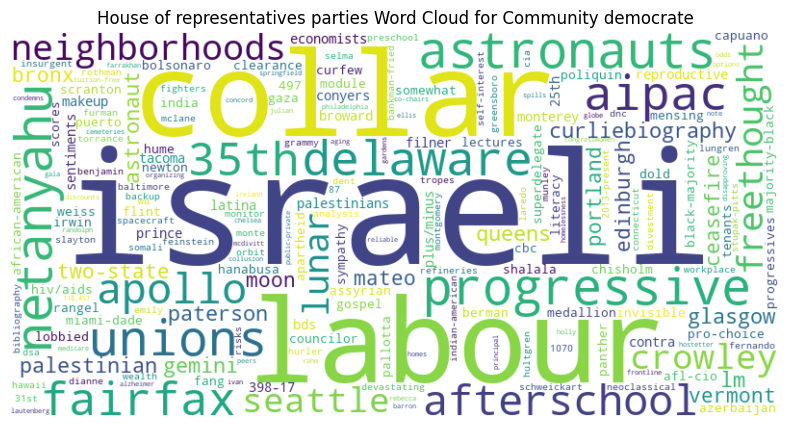

In [81]:
# Function to create and display word clouds for each community
def generate_wordclouds(community_ratio_lists_house_party, output_directory='usa_data/wordclouds'):
    # Create the output directory if it doesn't exist
    os.makedirs(output_directory, exist_ok=True)

    for community_house_party2, ratio_list_house_party in community_ratio_lists_house_party.items():

        # Sort the ratio list by value in descending order
        sorted_ratio_list_house_party2 = sorted(ratio_list_house_party.items(), key=lambda x: x[1], reverse=True)

        # Create a WordCloud object
        wordcloud_house_party = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(sorted_ratio_list_house_party2))

        # Plot the WordCloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud_house_party, interpolation='bilinear')
        plt.title(f'House of representatives parties Word Cloud for Community {community_house_party2}')
        plt.axis('off')

        # Save the plot
        save_path = os.path.join(output_directory, f'House_party_Wordcloud_community_{community_house_party2}.png')
        print(save_path)
        plt.savefig(save_path, bbox_inches='tight')

        # Show the plot
        plt.show()

# Generate and display word clouds for each community
generate_wordclouds(community_ratio_lists_house_party)

### 4.4.3 Senate - Party Communities 

In [82]:
senate_party_communities = {politician: community_id for politician, community_id in senate_communities.items()}
senate_party_communities = {k.replace(".",""): v for k, v in senate_party_communities.items()}
print(senate_party_communities)

{'Mark Warner': 0, 'Shelley Moore Capito': 1, 'Kyrsten Sinema': 2, 'Peter Welch': 0, 'Steve Daines': 1, 'Chuck Grassley': 1, 'Tommy Tuberville': 1, 'Cindy Hyde-Smith': 1, 'Jacky Rosen': 0, 'Ben Ray Lujan': 2, 'Tammy Duckworth': 0, 'Bill Cassidy': 1, 'Laphonza Butler': 0, 'Bob Menendez': 0, 'John Thune': 1, 'Mitt Romney': 1, 'Gary Peters': 0, 'Joni Ernst': 1, 'Pete Ricketts': 1, 'Chris Murphy': 0, 'Joe Manchin': 0, 'Chris Van Hollen': 0, 'Dick Durbin': 0, 'Lisa Murkowski': 1, 'John Cornyn': 1, 'Jon Ossoff': 0, 'Kevin Cramer': 1, 'Cory Booker': 0, 'Roger Wicker': 1, 'Catherine Cortez Masto': 0, 'J D Vance': 1, 'Jeff Merkley': 0, 'Roger Marshall': 1, 'Mike Crapo': 1, 'Cynthia Lummis': 1, 'Chris Coons': 0, 'Jerry Moran': 1, 'Markwayne Mullin': 1, 'Mitch McConnell': 1, 'Brian Schatz': 0, 'John Kennedy': 1, 'Todd Young': 1, 'John Boozman': 1, 'Mark Kelly': 0, 'Mazie Hirono': 0, 'Tim Kaine': 0, 'Sheldon Whitehouse': 0, 'Martin Heinrich': 0, 'Maggie Hassan': 0, 'Ted Budd': 1, 'Marsha Blackburn

In [83]:
# Create a nested dictionary. Outer key is the community id and the inner key is the politicians name.
#Each inner value will be a list of cleaned tokens
senate_party_tokens = defaultdict(lambda: defaultdict(list))

def cleaned_politician_texts(text, politician_names):
    tokens = word_tokenize(text)
    clean_tokens = []

    for token in tokens:
        # Convert to lowercase
        token = token.lower()

        # Remove punctuation and keep only alphanumeric words
        if token.isalnum():
            # Remove stopwords
            if token not in stopwords.words('english'):
                clean_tokens.append(token)

    # Filter out politician names
    clean_tokens = [token for token in clean_tokens if token.lower() not in politician_names]

    return clean_tokens



In [84]:
from nltk.tokenize import word_tokenize

def cleaned_politician_texts(text, politician_names):
    if not isinstance(text, str):
        return []  # Return an empty list if text is not a string

    # Convert politician names to lowercase
    politician_names_lower = {name.lower() for name in politician_names}

    # Split the text into words
    words = text.lower().split()

    # Remove politician names
    clean_words = [word for word in words if word not in politician_names_lower]

    return clean_words



In [85]:
import os
# Tokenize, clean, and filter politician names for each community
for filename in os.listdir(senators_directory):
    if filename.endswith('.txt'):
        politician_senate_party_name = os.path.splitext(filename)[0]  # Remove the '.txt' extension
        file_path = os.path.join(senators_directory, filename)

        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()
            cleaned_text = cleaned_politician_texts(text, all_politician_names)

            # Get the community ID for the politician
            community_id_senate_party = senate_party_communities.get(politician_senate_party_name)

            # Store the cleaned tokens under the corresponding community and politician
            senate_party_tokens[community_id_senate_party][politician_senate_party_name].extend(cleaned_text)

In [87]:
# Create a dictionary to store frequency lists for each community
community_frequency_lists_senate_party = defaultdict(dict)

# Create frequency lists for each community
for community, politicians in senate_party_tokens.items():
    aggregated_tokens_senate_party = [token for tokens in politicians.values() for token in tokens]
    frequency_list_senate_party = Counter(aggregated_tokens_senate_party)
    community_frequency_lists_senate_party[community] = frequency_list_senate_party

# Print community_frequency_lists 
#for community, frequency_list_senate_party in community_frequency_lists_senate_party.items():
#    print(f'Community: {community}, Frequency List: {frequency_list_senate_party}')

In [88]:
# Create a dictionary to store ratio lists for each community
community_ratio_lists_senate_party = defaultdict(dict)

# Add a constant to avoid division by zero
constant = 1

# Calculate ratio lists for each community
for current_community_senate_party, current_frequency_list_senate_party in community_frequency_lists_senate_party.items():
    other_communities_senate_party = [c for c in community_frequency_lists_senate_party if c != current_community_senate_party]

    for word_senate_party, frequency_senate_party in current_frequency_list_senate_party.items():
        total_frequency_other_communities_senate_party = sum(community_frequency_lists_senate_party[c][word_senate_party] for c in other_communities_senate_party) + constant
        ratio_senate_party = frequency_senate_party / total_frequency_other_communities_senate_party

        # Store the ratio for the word in the current community
        community_ratio_lists_senate_party[current_community_senate_party][word_senate_party] = ratio_senate_party

# Print community_ratio_lists
for community_senate_party2, ratio_list_senate_party in community_ratio_lists_senate_party.items():
    print(f'Community: {community_senate_party2}, Ratio List: {ratio_list_senate_party}')

Community: 0, Ratio List: {'alejandro': 0.5, '"alex"': 1.0, '(born': 0.8214285714285714, 'march': 0.7642276422764228, '22,': 0.7083333333333334, '1973)': 2.0, 'is': 0.8374512353706112, 'an': 0.7784090909090909, 'american': 1.0146627565982405, 'politician': 0.7586206896551724, 'serving': 0.891566265060241, 'as': 0.823090178058587, 'the': 0.8404023352324682, 'senior': 0.8928571428571429, 'united': 0.8449931412894376, 'states': 0.8861671469740634, 'senator': 0.8434237995824635, 'from': 0.8707280832095097, 'california,': 1.625, 'a': 0.8393384524512699, 'seat': 0.8235294117647058, 'he': 0.6742049469964664, 'has': 0.8596214511041009, 'held': 0.7583333333333333, 'since': 0.9800995024875622, '2021.': 0.6829268292682927, 'member': 0.9903846153846154, 'of': 0.8996564557686803, 'democratic': 1.4073170731707316, 'party,': 0.7121212121212122, 'served': 0.9023255813953488, '30th': 0.5, 'secretary': 1.59375, 'state': 0.8351648351648352, 'california': 2.0, '2015': 0.46774193548387094, 'to': 0.90036737

usa_data/wordclouds\Senate_party_Wordcloud_community_house.png


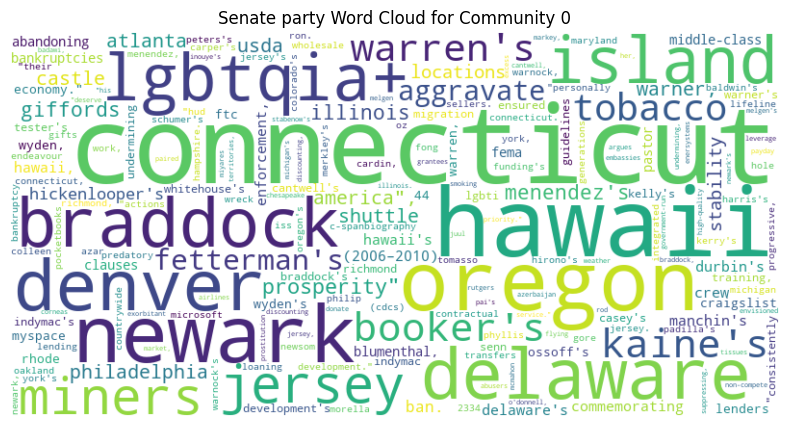

usa_data/wordclouds\Senate_party_Wordcloud_community_house.png


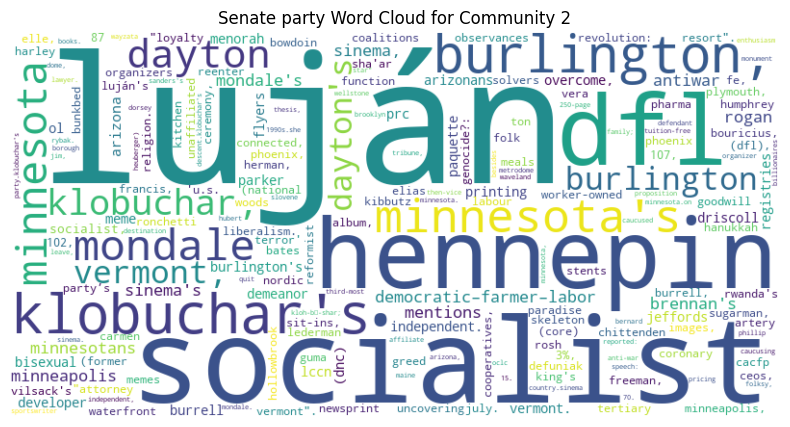

usa_data/wordclouds\Senate_party_Wordcloud_community_house.png


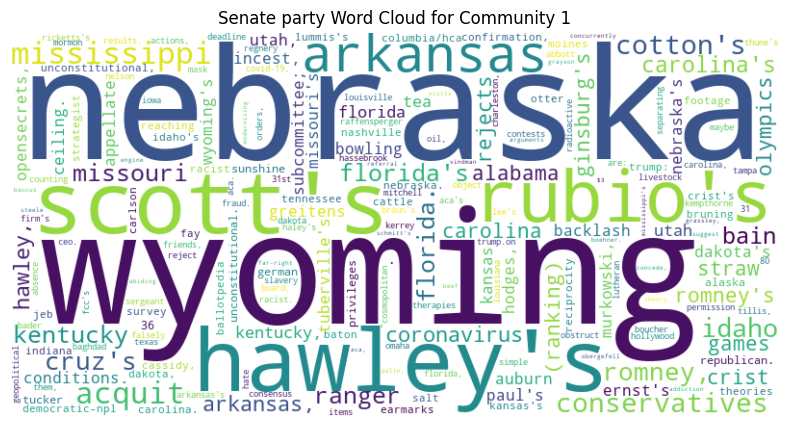

In [89]:
# Function to create and display word clouds for each community
def generate_wordclouds(community_ratio_lists_senate_party, output_directory='usa_data/wordclouds'):
    # Create the output directory if it doesn't exist
    os.makedirs(output_directory, exist_ok=True)

    for community_senate_party2, ratio_list_senate_party in community_ratio_lists_senate_party.items():
        if community_senate_party2 == "N/A":
            continue

        # Sort the ratio list by value in descending order
        sorted_ratio_list_senate_party = sorted(ratio_list_senate_party.items(), key=lambda x: x[1], reverse=True)

        # Create a WordCloud object
        wordcloud_senate_party = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(sorted_ratio_list_senate_party))

        # Plot the WordCloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud_senate_party, interpolation='bilinear')
        plt.title(f'Senate party Word Cloud for Community {community_senate_party2}')
        plt.axis('off')

        # Save the plot
        save_path = os.path.join(output_directory, f'Senate_party_Wordcloud_community_{community2}.png')
        print(save_path)
        plt.savefig(save_path, bbox_inches='tight')

        # Show the plot
        plt.show()

# Generate and display word clouds for each community
generate_wordclouds(community_ratio_lists_senate_party)

# 5 Sentiment analysis 


## 5.1 By chamber 

In [90]:
senators_directory = 'usa_data/senate/'
representatives_directory = 'usa_data/house/'

nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
afinn = Afinn()
analyzer = SentimentIntensityAnalyzer()

# Create a dictionary to store sentiment scores for each community
house_vs_sen_sent = {politician: community_id for politician, community_id in congress_chamber_partition.items()}
house_vs_sen_sents = {k.replace(".",""): v for k, v in congress_chamber_partition.items()}

house_tokens_afinn = dict()
house_tokens_vader = dict()
senate_tokens_afinn = dict()
senate_tokens_vader = dict()
# Load texts for senators

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Nikolai\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [91]:
for filename in os.listdir(senators_directory):
    if filename.endswith('.txt'):
        politician_name = os.path.splitext(filename)[0]  # Remove the '.txt' extension
        file_path = os.path.join(senators_directory, filename)

        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()
            file.close()
        
        cleaned_text = cleaned_politician_texts(text, all_politician_names)
        if len(cleaned_text) == 0:
            n_words = 1
        else:
            n_words = len(cleaned_text)
        
        cleaned_text = " ".join(cleaned_text)
        score_vader = analyzer.polarity_scores(cleaned_text)["compound"]
        score_afinn = afinn.score(cleaned_text)/n_words

        # Store the cleaned tokens under the corresponding community and politician
        senate_tokens_vader[politician_name] = score_vader
        senate_tokens_afinn[politician_name] = score_afinn

In [92]:
# Load texts for representatives
for filename in os.listdir(representatives_directory):
    if filename.endswith('.txt'):
        politician_name = os.path.splitext(filename)[0]  # Remove the '.txt' extension
        file_path = os.path.join(representatives_directory, filename)
        
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()
            file.close()
            
        cleaned_text = cleaned_politician_texts(text, all_politician_names)
        if len(cleaned_text) == 0:
            n_words = 1
        else:
            n_words = len(cleaned_text)
        # concatenate all the tokens into one string
        cleaned_text = " ".join(cleaned_text)
        score_afinn = afinn.score(cleaned_text)/n_words
        score_vader = analyzer.polarity_scores(cleaned_text)["compound"]

        # Store the cleaned tokens under the corresponding community and politician
        house_tokens_vader[politician_name] = score_vader
        house_tokens_afinn[politician_name] = score_afinn


In [93]:
# find average sentiment score for each community
print(np.mean(list(senate_tokens_afinn.values())))
print(np.mean(list(house_tokens_afinn.values())))

0.007183078236268069
0.007905077671465489


## 5.2 By party 

In [94]:
all_tokens_afinn = {**house_tokens_afinn, **senate_tokens_afinn}
all_tokens_afinn = {k.replace(".",""): v for k, v in all_tokens_afinn.items()}

# replace "." with "_" in the names
republicans = [i.replace(".","") for i in republicans]
democrats = [i.replace(".","") for i in democrats]


afinn_sentiment_democrats = [all_tokens_afinn[i] for i in democrats]

afinn_sentiment_republicans = [all_tokens_afinn[i] for i in republicans]

## 5.3 Boxplots 

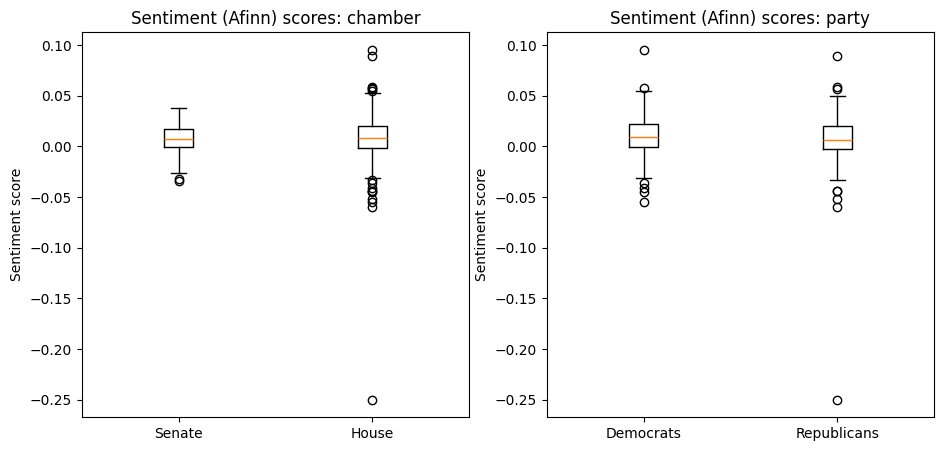

In [95]:
# make boxplot of the sentiment scores
data = [list(senate_tokens_afinn.values()), list(house_tokens_afinn.values()), afinn_sentiment_democrats, afinn_sentiment_republicans]

plt.figure(figsize=(11, 5))
plt.subplot(1,2,1)
plt.boxplot(data[:2])
plt.title("Sentiment (Afinn) scores: chamber")
plt.ylabel("Sentiment score")
plt.xticks([1, 2], ["Senate", "House"])

plt.subplot(1,2,2)
plt.boxplot(data[2:])
plt.title("Sentiment (Afinn) scores: party")
plt.ylabel("Sentiment score")
plt.xticks([1, 2], ["Democrats", "Republicans"])

# rotate x-axis labels
plt.xticks(rotation=0)
plt.savefig("usa_data/afinn_sentiment_scores.pdf", bbox_inches='tight')